# Fairness Exemplo 1

Ideia: Criar um Modelo de Predição simples a partir da base de dados "adult.csv" e checar de alguma forma se a restrição de independência está sendo cumprida para o atributo sensível RAÇA.

Independência: P{R = 1; A = a} = P{R = 1; A = b}; Para todo grupo a e b

Primeiro vou fazer um modelo simples, só inserindo tudo. Aparentemente a base já veio com tratamento de nulos, então provavelmente já foi feito um pré-processamento.

Importando as bibliotecas principais e recebendo os dados.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("C:\\Users\\murilo.pinheiro\\Documents\\Notebooks\\adult.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Separando os dados entre X e Y, onde Y é a variável alvo.
Após isso faço um split para termos os dados de teste e os de treino. Fixo um random_state para checar melhor os resultados.

In [3]:
x = data.drop(['income'], axis=1)
Y = data["income"]

from sklearn.model_selection import train_test_split

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size = 0.3)

Utilizo um Ordinal Encoder em todas as minhas variáveis categóricas presente em X, tanto em X-Treino como X-Teste.
Após fazer isso, eu faço uma coisa parecida com a variável alvo, basicamente torno ela um valor binário(1 ou 0).

In [4]:
from sklearn.preprocessing import OrdinalEncoder

categoricalLabels = (x_train.select_dtypes(include = ['object'])).columns

encoder = OrdinalEncoder(dtype = 'int32')

num_x_train = x_train.copy()
num_x_test = x_test.copy()

num_x_train[categoricalLabels] = encoder.fit_transform(x_train[categoricalLabels])
num_x_test[categoricalLabels] = encoder.transform(x_test[categoricalLabels])

num_Y_test = Y_test.apply(lambda p: 1 if p == '>50K' else 0)
num_Y_train = Y_train.apply(lambda p: 1 if p == '>50K' else 0)

# Classificador (Árvore de Decisão) 
Após isso, faço o modelo propriamente dito, utilizo um Classificador de Árvore de decisão e efetuo a predição, fixo um random_state para ter o mesmo MAE, mas o valor do MAE é cerca de 0.18, variando um pouco pra mais ou pra menos.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

modelo = DecisionTreeClassifier()

modelo.fit(num_x_train, num_Y_train)
previsao = modelo.predict(num_x_test)

acuraciaNP = mean_absolute_error(num_Y_test, previsao)
print(acuraciaNP)

0.18856206920084626


Aqui vem a parte final. Checar a independência, como não sei uma forma de quantificar tudo isso e não tive tempo de ver como a AIF360 funciona direitinho, resolvi fazer essa checagem por meio de gráficos. Um gráfico que mostra a proporção de pessoas que são classificadas, como positivas ou negativas, separadas por raça.

Primeiro eu inverto a transformação feita antes nas variáveis categóricas, após isso eu junto o X-Teste com a Previsão com os valores de Ŷ, que são os Y's do Classificador.
Após isso eu seleciono apenas os Atributos Raça e o Ŷ. Depois eu agrupo os dados a partir do Ŷ e conto os valores separados por raça.
Com isso, eu conto os valores apenas por Raça, para saber quantas pessoas eu tenho de cada Raça. Então eu faça uma Junção para ter um registro formado por:

Ŷ - Raça - Quantidade de Ŷ para aquela raça - Quantidade de Pessoas daquela raça.

OBS: Não sei se fazer essa junção era a maneira mais fácil de fazer o que eu fiz, mas foi a única que lembrei como fazer, talvez encontre uma forma melhor e mais rápida depois.

Para finalizar eu reverto a codificação binária que fiz no Y, e obtenho a Proporção de Ŷ para aquela raça a partir de:

(Quantidade de Ŷ para aquela raça) / (Quantidade de Pessoas daquela raça).

In [6]:
df = num_x_test.copy()
df[categoricalLabels] = encoder.inverse_transform(num_x_test[categoricalLabels])
df["income"] = previsao
df = df[["race", "income"]]
hue = "income"

dfe = pd.DataFrame(df.groupby('income').value_counts().rename("count").reset_index())

dfd = df["race"].value_counts()
dfd = dfd.reset_index()
dfe = dfe.merge(dfd, left_on='race', right_on='index')
dfe = dfe.drop("index", axis = 1)

dfe = dfe.rename(columns = {"race_x": "race", "race_y": "total"})
dfe["proportion"] = dfe["count"]/dfe["total"]*100

dfe['income'] = dfe["income"].apply(lambda p: '>50K' if p == 1 else '<=50K')

# Classificador (Árvore de Decisão) Protegido
A Partir daqui repito os passos para o Modelo Protegido

In [7]:
encoder2 = OrdinalEncoder(dtype = "int32")
modeloProtegido = DecisionTreeClassifier()

num_x_testProtected = x_test.copy()
num_x_trainProtected = x_train.copy()

raceTest = num_x_testProtected["race"]
num_x_testProtected = num_x_testProtected.drop(["race"], axis = 1)
num_x_trainProtected = num_x_trainProtected.drop(["race"], axis = 1)

categoricalLabelsProtected = (num_x_testProtected.select_dtypes(include = ['object'])).columns

num_x_trainProtected[categoricalLabelsProtected] = encoder2.fit_transform(x_train[categoricalLabelsProtected])
num_x_testProtected[categoricalLabelsProtected] = encoder2.transform(x_test[categoricalLabelsProtected])
print(categoricalLabelsProtected)

num_Y_testProtected = Y_test.apply(lambda p: 1 if p == '>50K' else 0)
num_Y_trainProtected = Y_train.apply(lambda p: 1 if p == '>50K' else 0)
#Não era preciso fazer isso porquê já foi feito antes mas vou refazer por via das Dúvidas e para não confundir

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'gender', 'native-country'],
      dtype='object')


In [8]:
modeloProtected = DecisionTreeClassifier()

modeloProtected.fit(num_x_trainProtected, num_Y_trainProtected)
previsaoProtected = modeloProtected.predict(num_x_testProtected)

acuraciaP = mean_absolute_error(num_Y_testProtected, previsaoProtected)
print(acuraciaP)

0.19054118610523443


In [9]:
dfProtected = num_x_testProtected.copy()
print(num_x_testProtected)
dfProtected[categoricalLabelsProtected] = encoder2.inverse_transform(num_x_testProtected[categoricalLabelsProtected])
dfProtected["income"] = previsaoProtected
dfProtected["race"] = raceTest
dfProtected = dfProtected[["race", "income"]]
hue = "income"

dfeProtected = pd.DataFrame(dfProtected.groupby('income').value_counts().rename("count").reset_index())

dfdProtected = dfProtected["race"].value_counts()
dfdProtected = dfdProtected.reset_index()
dfeProtected = dfeProtected.merge(dfdProtected, left_on='race', right_on='index')
dfeProtected = dfeProtected.drop("index", axis = 1)

dfeProtected = dfeProtected.rename(columns = {"race_x": "race", "race_y": "total"})
dfeProtected["proportion"] = dfeProtected["count"]/dfeProtected["total"]*100

dfeProtected['income'] = dfeProtected["income"].apply(lambda p: '>50K' if p == 1 else '<=50K')

       age  workclass  fnlwgt  education  educational-num  marital-status  \
3309    17          4   34465          1                7               4   
23176   21          4   35424         15               10               4   
48527   32          6  116508         15               10               2   
42156   62          4  115387         11                9               4   
45413   50          6  334273          9               13               2   
...    ...        ...     ...        ...              ...             ...   
3607    34          4  127651         11                9               2   
43502   48          6  107231          9               13               2   
37910   25          4   93223         15               10               0   
16298   32          4  186824         11                9               4   
45888   53          4  130143         11                9               2   

       occupation  relationship  gender  capital-gain  capital-loss  \
3309

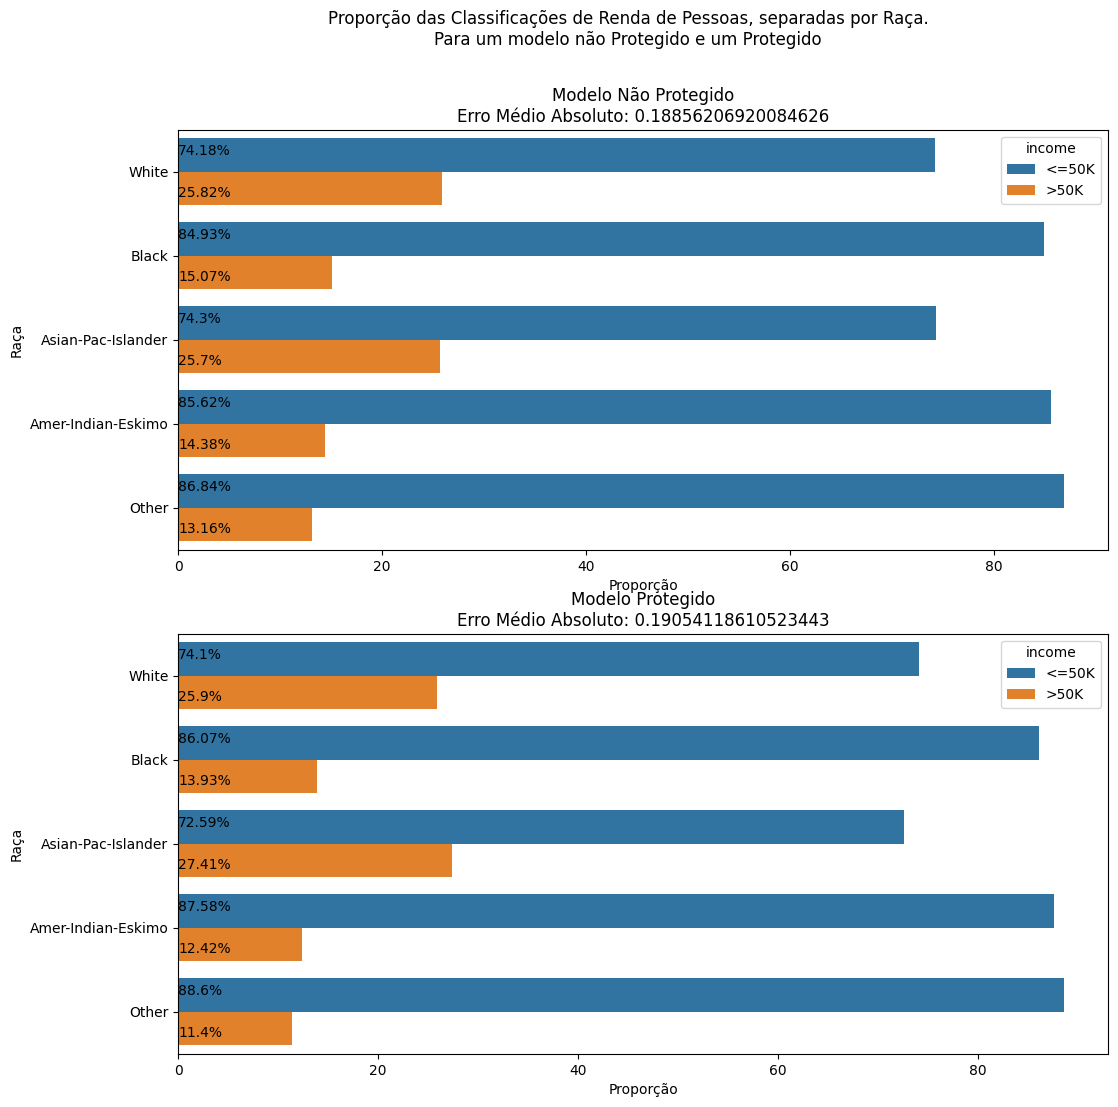

In [10]:
fig, ax = plt.subplots(2, 1, figsize = (12, 12))
fig.suptitle("Proporção das Classificações de Renda de Pessoas, separadas por Raça.\nPara um modelo não Protegido e um Protegido")

plot = sns.barplot(ax = ax[0], data = dfe,x = "proportion", y = "race", hue = "income")
plot.set_ylabel("Raça")
plot.set_xlabel("Proporção")

for index, row in dfe.iterrows():
    plot.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')
    
plot1 = sns.barplot(ax = ax[1], data = dfeProtected,x = "proportion", y = "race", hue = "income")
plot1.set_ylabel("Raça")
plot1.set_xlabel("Proporção")

for index, row in dfeProtected.iterrows():
    plot1.text(0, (row.name)/2 - 0.2, str(round(row.proportion, 2)) + "%",color='black')

ax[0].set_title("Modelo Não Protegido\nErro Médio Absoluto: " + str(acuraciaNP))
ax[1].set_title("Modelo Protegido\nErro Médio Absoluto: " + str(acuraciaP))
plt.show()
fig.savefig("output.png")

## Conclusão:
Os valores das Proporções, que nesse caso podem ser interpretados como Probabilidades, diferem bastante entre si, tanto no modelo protegido, quanto no não protegido, assim a restrição de Independência, ou Paridade Estatística, não estão sendo atendidas por esses Modelos.

OBS: Depois fazer esse processo utilizando métricas do AIF360.